In [1]:
from datasets import load_dataset
import gpn.model
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
d = load_dataset("gonzalobenegas/gxa-sorghum-v1", split="train")

In [3]:
d = d.filter(lambda x: x["chrom"] == "3" and x["start"] == 68_596_290 - 256)
d

Dataset({
    features: ['chrom', 'strand', 'start', 'end', 'seq', 'labels'],
    num_rows: 1
})

In [6]:
psbs = d[0]

In [8]:
psbs["labels"]

[6.938,
 8.409,
 1.065,
 1.131,
 0.833,
 0.55,
 7.004,
 5.784,
 3.412,
 5.899,
 4.543,
 0.0,
 2.037,
 4.485,
 0.0,
 0.47,
 2.037,
 0.36,
 0.182,
 0.0,
 0.0,
 0.0,
 4.547,
 0.659,
 4.585,
 4.263]

In [ ]:
track_idx = 1  # E-MTAB-4021_leaf mesophyll
y_true = psbs["labels"][track_idx]
y_true

8.409

In [9]:
tokenizer = AutoTokenizer.from_pretrained("songlab/tokenizer-dna-mlm")

In [12]:
input_ids = tokenizer(psbs["seq"], return_tensors="pt")["input_ids"]
input_ids.shape

torch.Size([1, 512])

In [11]:
input_ids.shape

torch.Size([1, 512])

In [33]:
def get_loss(checkpoint):
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint).eval()
    with torch.no_grad():
        y_pred = model(input_ids=input_ids).logits[0, track_idx].item()
    return (y_true - y_pred) ** 2

In [ ]:
steps_per_epoch = 265

checkpoints = [
    f"../../results/checkpoints_epoch/GPN_Brassicales/30_epochs/{seed}/checkpoint-{steps_per_epoch * i}"
    for i in range(1, 31)
    for seed in [
        42,
        43,
        44,
        45,
        46,
        # "merged",
    ]
]

res = pd.DataFrame(dict(checkpoint=checkpoints, loss=map(get_loss, tqdm(checkpoints))))
res["epoch"] = (
    res.checkpoint.str.extract(r"checkpoint-(\d+)").astype(int) // steps_per_epoch
)
res["seed"] = res.checkpoint.str.split("/").str[-2]
res

 18%|████████████████████▎                                                                                            | 27/150 [06:58<48:11, 23.51s/it]

In [ ]:
res

,checkpoint,loss,epoch,seed
0,../../results/checkpoints_epoch/GPN_Brassicale...,60.291796,1,42
1,../../results/checkpoints_epoch/GPN_Brassicale...,52.383779,1,43
2,../../results/checkpoints_epoch/GPN_Brassicale...,57.131370,1,44
3,../../results/checkpoints_epoch/GPN_Brassicale...,61.756514,1,45
4,../../results/checkpoints_epoch/GPN_Brassicale...,56.621897,1,46
...,...,...,...,...
145,../../results/checkpoints_epoch/GPN_Brassicale...,0.060376,30,42
146,../../results/checkpoints_epoch/GPN_Brassicale...,0.770335,30,43
147,../../results/checkpoints_epoch/GPN_Brassicale...,0.703485,30,44
148,../../results/checkpoints_epoch/GPN_Brassicale...,0.467087,30,45


In [ ]:
res

,checkpoint,loss,epoch,seed
0,../../results/checkpoints_epoch/GPN_Brassicale...,60.291796,1,42
1,../../results/checkpoints_epoch/GPN_Brassicale...,52.383779,1,43
2,../../results/checkpoints_epoch/GPN_Brassicale...,57.131370,1,44
3,../../results/checkpoints_epoch/GPN_Brassicale...,61.756514,1,45
4,../../results/checkpoints_epoch/GPN_Brassicale...,56.621897,1,46
...,...,...,...,...
145,../../results/checkpoints_epoch/GPN_Brassicale...,0.060376,30,42
146,../../results/checkpoints_epoch/GPN_Brassicale...,0.770335,30,43
147,../../results/checkpoints_epoch/GPN_Brassicale...,0.703485,30,44
148,../../results/checkpoints_epoch/GPN_Brassicale...,0.467087,30,45


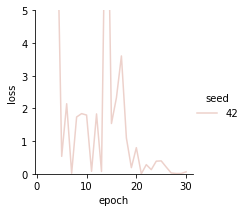

In [5]:
g = sns.relplot(
    kind="line",
    # data=res,
    data=res[res.seed == 42],
    x="epoch",
    y="loss",
    hue="seed",
    height=3,
)
plt.ylim(0, 5)
sns.despine();

In [2]:
# res.to_csv("train_loss_gene.csv", index=False)
res = pd.read_csv("train_loss_gene.csv")
res

,checkpoint,loss,epoch,seed
0,../../results/checkpoints_epoch/GPN_Brassicale...,60.291796,1,42
1,../../results/checkpoints_epoch/GPN_Brassicale...,52.383779,1,43
2,../../results/checkpoints_epoch/GPN_Brassicale...,57.131370,1,44
3,../../results/checkpoints_epoch/GPN_Brassicale...,61.756514,1,45
4,../../results/checkpoints_epoch/GPN_Brassicale...,56.621897,1,46
...,...,...,...,...
145,../../results/checkpoints_epoch/GPN_Brassicale...,0.060376,30,42
146,../../results/checkpoints_epoch/GPN_Brassicale...,0.770335,30,43
147,../../results/checkpoints_epoch/GPN_Brassicale...,0.703485,30,44
148,../../results/checkpoints_epoch/GPN_Brassicale...,0.467087,30,45


In [ ]:
res2 = []
for checkpoint in checkpoints:
    ckpt = checkpoint.replace("../../results/", "")
    df = pd.read_csv(f"../../results/experimental_data/metrics/PsbS/{ckpt}.csv")
    df = df[(df.subset == "all") & (df.variant_type == "all")]
    df["checkpoint"] = checkpoint
    res2.append(df)
res2 = pd.concat(res2)

In [ ]:
# res_original = res.copy()

In [ ]:
res = res.merge(res2, how="inner", on="checkpoint")
res

,checkpoint,loss,epoch,seed,subset,variant_type,n_variants,Pearson,Spearman
0,../../results/checkpoints_epoch/GPN_Brassicale...,60.291796,1,42,all,all,1127,-0.055947,-0.034061
1,../../results/checkpoints_epoch/GPN_Brassicale...,52.383779,1,43,all,all,1127,0.239139,0.224505
2,../../results/checkpoints_epoch/GPN_Brassicale...,57.131370,1,44,all,all,1127,0.077761,0.077783
3,../../results/checkpoints_epoch/GPN_Brassicale...,61.756514,1,45,all,all,1127,-0.052940,-0.022331
4,../../results/checkpoints_epoch/GPN_Brassicale...,56.621897,1,46,all,all,1127,0.061850,0.101643
...,...,...,...,...,...,...,...,...,...
145,../../results/checkpoints_epoch/GPN_Brassicale...,0.060376,30,42,all,all,1127,0.328887,0.233912
146,../../results/checkpoints_epoch/GPN_Brassicale...,0.770335,30,43,all,all,1127,0.247201,0.131102
147,../../results/checkpoints_epoch/GPN_Brassicale...,0.703485,30,44,all,all,1127,0.205015,0.178336
148,../../results/checkpoints_epoch/GPN_Brassicale...,0.467087,30,45,all,all,1127,0.191422,0.146777


In [ ]:
res = res.rename(
    columns={"Pearson": "Pearson across PsbS variants", "loss": "train loss on PsbS"}
)
res

,checkpoint,train loss on PsbS,epoch,seed,subset,variant_type,n_variants,Pearson across PsbS variants,Spearman
0,../../results/checkpoints_epoch/GPN_Brassicale...,60.291796,1,42,all,all,1127,-0.055947,-0.034061
1,../../results/checkpoints_epoch/GPN_Brassicale...,52.383779,1,43,all,all,1127,0.239139,0.224505
2,../../results/checkpoints_epoch/GPN_Brassicale...,57.131370,1,44,all,all,1127,0.077761,0.077783
3,../../results/checkpoints_epoch/GPN_Brassicale...,61.756514,1,45,all,all,1127,-0.052940,-0.022331
4,../../results/checkpoints_epoch/GPN_Brassicale...,56.621897,1,46,all,all,1127,0.061850,0.101643
...,...,...,...,...,...,...,...,...,...
145,../../results/checkpoints_epoch/GPN_Brassicale...,0.060376,30,42,all,all,1127,0.328887,0.233912
146,../../results/checkpoints_epoch/GPN_Brassicale...,0.770335,30,43,all,all,1127,0.247201,0.131102
147,../../results/checkpoints_epoch/GPN_Brassicale...,0.703485,30,44,all,all,1127,0.205015,0.178336
148,../../results/checkpoints_epoch/GPN_Brassicale...,0.467087,30,45,all,all,1127,0.191422,0.146777


PearsonRResult(statistic=-0.42553332159034923, pvalue=5.686255096267428e-08)
SignificanceResult(statistic=-0.16595759811547178, pvalue=0.04239204334488932)


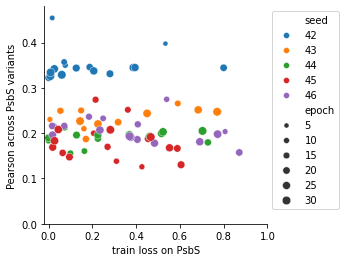

In [ ]:
x = "train loss on PsbS"
y = "Pearson across PsbS variants"
plt.figure(figsize=(4, 4))
g = sns.scatterplot(
    data=res,
    x=x,
    y=y,
    hue="seed",
    size="epoch",
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
pearson = pearsonr(res[x], res[y])
spearman = spearmanr(res[x], res[y])
print(pearson)
print(spearman)
g.set(
    xlim=(-0.02, 1),
    ylim=0,
    # aspect=1,
)
sns.despine();

In [ ]:
res.groupby("seed")["train loss on PsbS"].mean()

KeyError: 'Column not found: train loss on PsbS'

In [ ]:
res

,subset,variant_type,n_variants,Pearson,Spearman,gene,checkpoint,epoch,seed,subset2
0,all,all,1127,-0.055947,-0.034061,PsbS,checkpoints_epoch/GPN_Brassicales/30_epochs/42...,1,42,"[-256, 0)"
1,all,substitution,644,0.079738,0.076040,PsbS,checkpoints_epoch/GPN_Brassicales/30_epochs/42...,1,42,"[-256, 0)"
2,all,insertion,209,-0.232512,-0.218805,PsbS,checkpoints_epoch/GPN_Brassicales/30_epochs/42...,1,42,"[-256, 0)"
3,all,deletion,274,0.008818,-0.022637,PsbS,checkpoints_epoch/GPN_Brassicales/30_epochs/42...,1,42,"[-256, 0)"
4,all,12bp_deletion,136,0.028462,0.039866,PsbS,checkpoints_epoch/GPN_Brassicales/30_epochs/42...,1,42,"[-256, 0)"
...,...,...,...,...,...,...,...,...,...,...
20,less_than_50,all,76,0.241828,0.290081,Raf1,checkpoints_epoch/GPN_Brassicales/30_epochs/me...,30,merged,"[-50, 0)"
21,less_than_50,substitution,59,0.303741,0.388059,Raf1,checkpoints_epoch/GPN_Brassicales/30_epochs/me...,30,merged,"[-50, 0)"
22,less_than_50,insertion,12,0.241065,0.223776,Raf1,checkpoints_epoch/GPN_Brassicales/30_epochs/me...,30,merged,"[-50, 0)"
23,less_than_50,deletion,5,-0.397772,-0.300000,Raf1,checkpoints_epoch/GPN_Brassicales/30_epochs/me...,30,merged,"[-50, 0)"
